# Определение перспективного тарифа для телеком-компании

**Описание проекта**

Компания «Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагается два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, необходимо понять, какой тариф приносит больше денег.
В рамках исследования необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.


**Описание тарифов**

**Тариф «Смарт»**
1.	Ежемесячная плата: 550 рублей
2.	Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3.	Стоимость услуг сверх тарифного пакета: 1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 2. сообщение: 3 рубля; 3. 1 Гб интернет-трафика: 200 рублей.  

**Тариф «Ультра»**
1.	Ежемесячная плата: 1950 рублей
2.	Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3.	Стоимость услуг сверх тарифного пакета: 1. минута разговора: 1 рубль; 2. сообщение: 1 рубль; 3. 1 Гб интернет-трафика: 150 рублей.

**Примечание:**  
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.


## Изучение и обработка данных из файлов

### Описание данных

**Таблица users (информация о пользователях):**  
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tarif — название тарифного плана


**Таблица calls (информация о звонках):**
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок


**Таблица messages (информация о сообщениях):**
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение


**Таблица internet (информация об интернет-сессиях):**
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя


**Таблица tariffs (информация о тарифах):**
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)


### Загрузка и осмотр датасетов

In [1]:
#Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from pymystem3 import Mystem
from collections import Counter
from scipy import stats as st

In [2]:
#Сформируем датасеты
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

#### Изучим датасет со звонками

In [3]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [4]:
calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


In [5]:
calls.sample(random_state = None, n = 5)

,id,call_date,duration,user_id
199007,1490_353,2018-04-26,2.41,1490
79067,1197_59,2018-11-24,0.00,1197
195833,1480_144,2018-03-14,1.68,1480
160628,1395_289,2018-08-30,1.32,1395
173494,1428_183,2018-10-03,2.35,1428


Звонки с нулевой продолжительностью не ошибка: нулями обозначены пропущенные звонки, поэтому их не нужно удалять.  
Нужно поменять тип на DataTime в "call_date	".


#### Изучим датасет с интернетом

In [6]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [7]:
internet.describe()

,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


In [8]:
internet.sample(5)

,Unnamed: 0,id,mb_used,session_date,user_id
9809,9809,1033_189,108.14,2018-07-17,1033
135577,135577,1454_268,310.86,2018-08-08,1454
124289,124289,1419_9,175.77,2018-12-09,1419
104595,104595,1354_110,836.96,2018-12-17,1354
72586,72586,1244_418,407.89,2018-09-19,1244


Нужно поменять тип на DataTime в "session_date". Есть абоненты, которые не пользуются интернетом.  
Столбец 'Unnamed: 0' содержит дублирующие данные (индексы). Удалим этот столбец.


#### Изучим датасет с сообщениями
    

In [9]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [10]:
messages.sample(5)

,id,message_date,user_id
14149,1059_166,2018-12-31,1059
18865,1083_54,2018-07-10,1083
98476,1403_0,2018-07-13,1403
18317,1080_263,2018-10-06,1080
97199,1396_850,2018-05-30,1396


Нужно поменять тип на DataTime в "message_date"

#### Изучим датасет с тарифами

In [11]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [12]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


#### Изучим датасет с пользователями

In [13]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [14]:
users.describe()

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


In [15]:
users.tail(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart
499,1499,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart


In [16]:
users.sample(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
268,1268,18,NaN,Москва,Трофим,Трошин,2018-05-28,smart
439,1439,62,NaN,Орёл,Евгения,Афонина,2018-06-30,smart
215,1215,55,NaN,Рязань,Руслан,Алиев,2018-08-12,smart
153,1153,59,NaN,Ульяновск,Евдокия,Одинцова,2018-10-18,smart
412,1412,63,NaN,Волгоград,Геодар,Афонин,2018-06-05,ultra
137,1137,64,NaN,Кемерово,Ким,Артёшин,2018-12-02,smart
323,1323,67,NaN,Челябинск,Эсмеральда,Носкова,2018-08-02,smart
415,1415,41,NaN,Москва,Андрей,Лукин,2018-06-29,ultra
409,1409,42,NaN,Набережные Челны,Даниил,Алиев,2018-03-14,smart
304,1304,68,NaN,Владимир,Илья,Соловьёв,2018-11-05,ultra


Есть пропущенные значения в "churn_date" (дата прекращения пользования тарифом). Согласно условиям, если значение пропущено, то тариф ещё действовал на момент выгрузки данных.

### Выводы 

Нужно справить неверный формат даты в таблицах.  
Нужно округлить время звонков и мегабайты трафика в большую сторону в соответствии с условиями тарифов

## Предобработка данных

### Приведение данных к нужным типам

Во всех столбцах с датой, меняем тип на date_time и задаем формат

In [17]:
calls['call_date']=pd.to_datetime(calls['call_date'],format='%Y-%m-%d')

In [18]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

In [19]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

In [20]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

In [21]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

### Обработка и исправление ошибок в данных

In [25]:
#Проверим дибликаты
def dataset_duplicated(name_dataset): 
    print("Обнаружено дубликатов:", name_dataset.duplicated().sum())
        
for ds in [calls, internet, messages, tariffs, users]:
    print()
    dataset_duplicated(ds)



Обнаружено дубликатов: 0

Обнаружено дубликатов: 0

Обнаружено дубликатов: 0

Обнаружено дубликатов: 0

Обнаружено дубликатов: 0


In [26]:
users.duplicated().sum()

0

In [27]:
#Проверим уникальность id
users['user_id'].value_counts()

1023    1
1194    1
1181    1
1182    1
1183    1
       ..
1362    1
1363    1
1364    1
1365    1
1024    1
Name: user_id, Length: 500, dtype: int64

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт.  
Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.


Для веб-трафика отдельные сессии не считаются.  
Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

In [28]:
#Округлим продолжительность звонков
calls['duration'] = np.ceil(calls['duration']).astype('Int64')

In [29]:
internet.head(5)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [31]:
internet.head(5)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [32]:
#Столбец 'Unnamed: 0' содержит дублирующие данные (индексы). Удалим этот столбец.
internet.drop('Unnamed: 0', axis=1, inplace=True)
#Проверим, как прошло удаление
internet.sample(5)

,id,mb_used,session_date,user_id
134205,1450_88,98.25,2018-10-31,1450
19071,1065_216,186.19,2018-08-31,1065
91349,1308_532,366.31,2018-05-10,1308
56497,1188_303,140.81,2018-08-18,1188
126686,1425_215,469.29,2018-08-01,1425


Данные в исходных таблицах скорректированы, можно приступать к рассчётам

### Расчёты и добавление результатов в таблицу¶

Посчитаем для каждого пользователя: 
- количество сделанных звонков и израсходованных минут разговора по месяцам
- количество отправленных сообщений по месяцам
- объем израсходованного интернет-трафика по месяцам

In [33]:
#добавляем столбец month
calls['month'] = pd.to_datetime(calls['call_date']).dt.month
messages['month'] = pd.to_datetime(messages['message_date']).dt.month
internet['month'] = pd.to_datetime(internet['session_date']).dt.month

Посчитаем количество сделанных звонков и израсходованных минут разговора по месяцам

In [34]:
user_calls = calls.groupby(['user_id', 'month'])\
                  .agg({'duration':'sum', 'id':'count'})\
                  .reset_index()\
                  .rename(columns={'duration':'month_calls_duration','id':'calls_total_in_month'})\

user_calls.head()

,user_id,month,month_calls_duration,calls_total_in_month
0,1000,5,159,22
1,1000,6,172,43
2,1000,7,340,47
3,1000,8,408,52
4,1000,9,466,58


Посчитаем количество отправленных сообщений по месяцам


In [35]:
user_messages = messages.groupby(['user_id', 'month'])\
                        .agg({'id':'count'})\
                        .reset_index()\
                        .rename(columns={'id':'sms_total_in_month'})

In [36]:
user_messages.head()

,user_id,month,sms_total_in_month
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


Посчитаем объем израсходованного интернет-трафика по месяцам

In [37]:
user_internet = internet.groupby(['user_id', 'month'])\
                        .agg({'mb_used':'sum'})\
                        .reset_index()\
                        .rename(columns={'mb_used':'mb_total_in_month'})

user_internet.head(15)

,user_id,month,mb_total_in_month
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91
5,1000,10,14702.49
6,1000,11,14756.47
7,1000,12,9817.61
8,1001,11,18429.34
9,1001,12,14036.66


**Посчитаем для каждого пользователя помесячную выручку с каждого пользователя.**  
Вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; 
остаток умножим на значение из тарифного плана; 
прибавим абонентскую плату, соответствующую тарифному плану

In [38]:
#Сформируем общую таблицу использования минут, смс и интернета для каждого id (помесячно)
df = user_calls.merge(user_messages, on=['user_id','month'], how='outer')
df = df.merge(user_internet, on=['user_id','month'], how = 'outer')
df.head(10)

,user_id,month,month_calls_duration,calls_total_in_month,sms_total_in_month,mb_total_in_month
0,1000,5,159,22.0,22.0,2253.49
1,1000,6,172,43.0,60.0,23233.77
2,1000,7,340,47.0,75.0,14003.64
3,1000,8,408,52.0,81.0,14055.93
4,1000,9,466,58.0,57.0,14568.91
5,1000,10,350,57.0,73.0,14702.49
6,1000,11,338,43.0,58.0,14756.47
7,1000,12,333,46.0,70.0,9817.61
8,1001,11,430,59.0,NaN,18429.34
9,1001,12,414,63.0,NaN,14036.66


In [39]:
#Добавим данные абонентов снова сцепив по 'user_id'
df = df.merge(users, on='user_id', how='left')
df.head(10)

,user_id,month,month_calls_duration,calls_total_in_month,sms_total_in_month,mb_total_in_month,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5,159,22.0,22.0,2253.49,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6,172,43.0,60.0,23233.77,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7,340,47.0,75.0,14003.64,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8,408,52.0,81.0,14055.93,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9,466,58.0,57.0,14568.91,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
5,1000,10,350,57.0,73.0,14702.49,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
6,1000,11,338,43.0,58.0,14756.47,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
7,1000,12,333,46.0,70.0,9817.61,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
8,1001,11,430,59.0,NaN,18429.34,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
9,1001,12,414,63.0,NaN,14036.66,41,NaT,Москва,Иван,Ежов,2018-11-01,smart


In [40]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Для дальнейшего объединения таблиц, нам необходимо изменить названия столбца назание тарифа в tariffs.

In [41]:
tariffs = tariffs.rename(columns={'tariff_name':'tariff'})

In [42]:
#Добавим к получившейся таблице данные о тарифах (что входит в пакет) сцепив по 'tariff'
df = df.merge(tariffs, on='tariff', how='left')
df.tail(10)

,user_id,month,month_calls_duration,calls_total_in_month,sms_total_in_month,mb_total_in_month,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
3204,1473,9,NaN,NaN,19.0,17289.85,18,NaT,Красноярск,Николай,Лебедев,2018-08-05,ultra,1000,30720,3000,1950,150,1,1
3205,1473,10,NaN,NaN,20.0,13688.65,18,NaT,Красноярск,Николай,Лебедев,2018-08-05,ultra,1000,30720,3000,1950,150,1,1
3206,1473,11,NaN,NaN,14.0,21673.80,18,NaT,Красноярск,Николай,Лебедев,2018-08-05,ultra,1000,30720,3000,1950,150,1,1
3207,1473,12,NaN,NaN,20.0,18418.26,18,NaT,Красноярск,Николай,Лебедев,2018-08-05,ultra,1000,30720,3000,1950,150,1,1
3208,1489,8,NaN,NaN,17.0,11050.56,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3
3209,1489,9,NaN,NaN,32.0,17206.30,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3
3210,1489,10,NaN,NaN,21.0,19559.44,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3
3211,1489,11,NaN,NaN,20.0,17491.56,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3
3212,1489,12,NaN,NaN,35.0,17322.51,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3
3213,1476,4,NaN,NaN,NaN,530.78,50,NaT,Москва,Валентина,Семенова,2018-04-30,ultra,1000,30720,3000,1950,150,1,1


Исправим значения NaN на 0, это допустимо, так как пользователи с NaN по факту использовали в своём тарифе 0 минут, 0 смс, о Гб. Посмотрим, сколько у нас таких абонентов с 0 значениями.

In [43]:
df.isna().sum()

user_id                     0
month                       0
month_calls_duration       40
calls_total_in_month       40
sms_total_in_month        497
mb_total_in_month          11
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64

In [45]:
df[['sms_total_in_month', 'mb_total_in_month', 'month_calls_duration', 'calls_total_in_month']] = df[['sms_total_in_month', 'mb_total_in_month', 'month_calls_duration', 'calls_total_in_month']].fillna(0)

In [46]:
#Проверим NaN
df.isna().sum()

user_id                     0
month                       0
month_calls_duration        0
calls_total_in_month        0
sms_total_in_month          0
mb_total_in_month           0
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64

In [47]:
#Проверим еще раз дибликаты, не появились ли они после объединения данных в общую таблицу
df.duplicated().sum()

0

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 20 columns):
user_id                  3214 non-null int64
month                    3214 non-null int64
month_calls_duration     3214 non-null Int64
calls_total_in_month     3214 non-null float64
sms_total_in_month       3214 non-null float64
mb_total_in_month        3214 non-null float64
age                      3214 non-null int64
churn_date               187 non-null datetime64[ns]
city                     3214 non-null object
first_name               3214 non-null object
last_name                3214 non-null object
reg_date                 3214 non-null datetime64[ns]
tariff                   3214 non-null object
messages_included        3214 non-null int64
mb_per_month_included    3214 non-null int64
minutes_included         3214 non-null int64
rub_monthly_fee          3214 non-null int64
rub_per_gb               3214 non-null int64
rub_per_message          3214 non-null int64
rub_per_min

Так как перерасход начисляется за гигабайты, логичнее весь Интернет трафик перевести в ГБ и переименовать столбцы

In [49]:
df['mb_total_in_month'] = np.ceil(df['mb_total_in_month'] / 1024).astype(int)
df['mb_per_month_included'] = np.ceil(df['mb_per_month_included'] / 1024).astype(int)

df = df.rename(columns={'mb_total_in_month': 'gb_total_in_month'})
df = df.rename(columns={'mb_per_month_included': 'gb_per_month_included'})


In [50]:
df.head()

,user_id,month,month_calls_duration,calls_total_in_month,sms_total_in_month,gb_total_in_month,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,159,22.0,22.0,3,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30,3000,1950,150,1,1
1,1000,6,172,43.0,60.0,23,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30,3000,1950,150,1,1
2,1000,7,340,47.0,75.0,14,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30,3000,1950,150,1,1
3,1000,8,408,52.0,81.0,14,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30,3000,1950,150,1,1
4,1000,9,466,58.0,57.0,15,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30,3000,1950,150,1,1


In [51]:
#Часть столбцов скрывается. Настроим принудительное отображение
pd.set_option('display.max_columns', None)

In [53]:
df['minutes_overrun']  = [max(x -y, 0) for x, y in zip(df['month_calls_duration'], df['minutes_included'])]
df['messages_overrun']  = [max(x -y, 0) for x, y in zip(df['sms_total_in_month'], df['messages_included'])]
df['gb_overrun']  = [max(x -y, 0) for x, y in zip(df['gb_total_in_month'], df['gb_per_month_included'])]

In [54]:
df.query('minutes_overrun != 0').head(10)

,user_id,month,month_calls_duration,calls_total_in_month,sms_total_in_month,gb_total_in_month,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,minutes_overrun,messages_overrun,gb_overrun
32,1005,3,606,77.0,56.0,11,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,50,15,500,550,200,3,3,106,6.0,0
33,1005,4,712,101.0,41.0,10,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,50,15,500,550,200,3,3,212,0.0,0
34,1005,5,595,73.0,42.0,8,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,50,15,500,550,200,3,3,95,0.0,0
35,1005,6,612,80.0,47.0,10,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,50,15,500,550,200,3,3,112,0.0,0
36,1005,7,569,77.0,56.0,8,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,50,15,500,550,200,3,3,69,6.0,0
37,1005,8,619,71.0,64.0,8,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,50,15,500,550,200,3,3,119,14.0,0
39,1005,10,723,100.0,44.0,8,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,50,15,500,550,200,3,3,223,0.0,0
40,1005,11,547,75.0,51.0,13,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,50,15,500,550,200,3,3,47,1.0,0
41,1005,12,592,84.0,54.0,9,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,50,15,500,550,200,3,3,92,4.0,0
55,1007,6,545,68.0,26.0,14,65,NaT,Москва,Юна,Березина,2018-04-19,smart,50,15,500,550,200,3,3,45,0.0,0


Напишем функцию, которая считет выручку исходя из тарифа и потребляемых услуг

In [55]:
def get_revenue(row):
    revenue_by_min = 0
    revenue_by_messages = 0
    revenue_gb = 0

    if row['minutes_overrun'] > 0:
        revenue_by_min = row['minutes_overrun'] * row['rub_per_minute'] #стоимость минут потраченных сверх тарифа

    if row['messages_overrun'] > 0:
        revenue_by_messages = row['messages_overrun'] * row['rub_per_message'] #стоимость сообщений потраченных сверх тарифа
        
    if row['gb_overrun'] > 0:
        revenue_gb = row['gb_overrun'] * row['rub_per_gb'] #стоимость гб потраченных сверх тарифа       

    return revenue_by_min + revenue_by_messages + revenue_gb

In [56]:
df['revenue'] = df.apply(get_revenue, axis=1)

In [57]:
df.sample(10)

,user_id,month,month_calls_duration,calls_total_in_month,sms_total_in_month,gb_total_in_month,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,minutes_overrun,messages_overrun,gb_overrun,revenue
1884,1300,11,658,88.0,170.0,44,40,NaT,Москва,Тихон,Азерников,2018-07-26,ultra,1000,30,3000,1950,150,1,1,0,0.0,14,2100.0
3147,1495,9,813,112.0,82.0,33,65,NaT,Иркутск,Авксентий,Фокин,2018-08-28,ultra,1000,30,3000,1950,150,1,1,0,0.0,3,450.0
3031,1476,6,491,62.0,4.0,15,50,NaT,Москва,Валентина,Семенова,2018-04-30,ultra,1000,30,3000,1950,150,1,1,0,0.0,0,0.0
588,1094,9,717,105.0,18.0,22,37,NaT,Новосибирск,Даниэла,Пугачева,2018-05-28,ultra,1000,30,3000,1950,150,1,1,0,0.0,0,0.0
2207,1354,11,300,41.0,90.0,27,56,NaT,Сочи,Лола,Кулагина,2018-08-19,smart,50,15,500,550,200,3,3,0,40.0,12,2520.0
1499,1240,8,457,54.0,0.0,48,30,NaT,Воронеж,Зинаида,Шарова,2018-02-27,ultra,1000,30,3000,1950,150,1,1,0,0.0,18,2700.0
2248,1360,7,833,118.0,0.0,13,46,NaT,Санкт-Петербург,Лаура,Макарова,2018-03-18,ultra,1000,30,3000,1950,150,1,1,0,0.0,0,0.0
515,1081,11,649,94.0,17.0,17,42,NaT,Москва,Софья,Терехова,2018-03-25,ultra,1000,30,3000,1950,150,1,1,0,0.0,0,0.0
3127,1491,8,611,74.0,49.0,17,56,NaT,Челябинск,Радислав,Андрейкин,2018-04-25,ultra,1000,30,3000,1950,150,1,1,0,0.0,0,0.0
1274,1202,9,75,11.0,20.0,9,22,NaT,Владивосток,Адам,Адаменко,2018-09-20,smart,50,15,500,550,200,3,3,0,0.0,0,0.0


Мы рассчитали переплату за превышение пакетных услуг для каждого пользователя, теперь найдём общую выручку, добавив стоимость абонентской платы за тариф к переплате.

In [58]:
df['income'] = df['revenue'] + df['rub_monthly_fee']
df

,user_id,month,month_calls_duration,calls_total_in_month,sms_total_in_month,gb_total_in_month,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,minutes_overrun,messages_overrun,gb_overrun,revenue,income
0,1000,5,159,22.0,22.0,3,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30,3000,1950,150,1,1,0,0.0,0,0.0,1950.0
1,1000,6,172,43.0,60.0,23,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30,3000,1950,150,1,1,0,0.0,0,0.0,1950.0
2,1000,7,340,47.0,75.0,14,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30,3000,1950,150,1,1,0,0.0,0,0.0,1950.0
3,1000,8,408,52.0,81.0,14,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30,3000,1950,150,1,1,0,0.0,0,0.0,1950.0
4,1000,9,466,58.0,57.0,15,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30,3000,1950,150,1,1,0,0.0,0,0.0,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,9,0,0.0,32.0,17,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15,500,550,200,3,3,0,0.0,2,400.0,950.0
3210,1489,10,0,0.0,21.0,20,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15,500,550,200,3,3,0,0.0,5,1000.0,1550.0
3211,1489,11,0,0.0,20.0,18,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15,500,550,200,3,3,0,0.0,3,600.0,1150.0
3212,1489,12,0,0.0,35.0,17,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15,500,550,200,3,3,0,0.0,2,400.0,950.0


Мы привели исходные данные к нужным типам, обработали ошибки, объединили данные из нескольких таблиц в одну удобную и рассчитали новые столбцы.
Нам удалось выяснить переплату каждого абонента за использование услуг сверх своего тарифного плана и ощую сумму выручки с каждого абонента.

## Анализ данных

Опишем поведение клиентов оператора, исходя из выборки.  
1. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. 
2. Посчитаем среднее количество, дисперсию и стандартное отклонение.
3. Построим гистограммы.
4. Опишем распределения.

In [59]:
#вспомним условия тарифов, чтобы сравнить с показателями describe
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Для удобства обращения к данным, разделим общую таблицу на 2 по используемую абонентом тарифу Smart и Ultra.  
Проанализируем каждую из этих таблиц.

In [60]:
#Посмотрим количество строк для каждого тарифа
df['tariff'].value_counts()

smart    2229
ultra     985
Name: tariff, dtype: int64

### Анализ тарифа 'Smart'


In [61]:
smart_df=df.query('tariff == "smart"')
smart_df.describe().round()

,user_id,month,month_calls_duration,calls_total_in_month,sms_total_in_month,gb_total_in_month,age,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,minutes_overrun,messages_overrun,gb_overrun,revenue,income
count,2229.0,2229.0,2229.0,2229.0,2229.0,2229.0,2229.0,2229.0,2229.0,2229.0,2229.0,2229.0,2229.0,2229.0,2229.0,2229.0,2229.0,2229.0,2229.0
mean,1247.0,8.0,418.0,58.0,33.0,16.0,47.0,50.0,15.0,500.0,550.0,200.0,3.0,3.0,42.0,6.0,3.0,740.0,1290.0
std,146.0,3.0,190.0,26.0,28.0,6.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,85.0,13.0,4.0,818.0,818.0
min,1001.0,1.0,0.0,0.0,0.0,0.0,18.0,50.0,15.0,500.0,550.0,200.0,3.0,3.0,0.0,0.0,0.0,0.0,550.0
25%,1121.0,6.0,282.0,40.0,10.0,13.0,32.0,50.0,15.0,500.0,550.0,200.0,3.0,3.0,0.0,0.0,0.0,0.0,550.0
50%,1239.0,9.0,422.0,60.0,28.0,17.0,47.0,50.0,15.0,500.0,550.0,200.0,3.0,3.0,0.0,0.0,2.0,473.0,1023.0
75%,1376.0,11.0,545.0,76.0,51.0,20.0,62.0,50.0,15.0,500.0,550.0,200.0,3.0,3.0,45.0,1.0,5.0,1200.0,1750.0
max,1499.0,12.0,1435.0,198.0,143.0,38.0,75.0,50.0,15.0,500.0,550.0,200.0,3.0,3.0,935.0,93.0,23.0,6220.0,6770.0


#### Анализ звонков

In [62]:
smart_df['month_calls_duration'].describe().round()

count    2229.0
mean      418.0
std       190.0
min         0.0
25%       282.0
50%       422.0
75%       545.0
max      1435.0
Name: month_calls_duration, dtype: float64

In [63]:
variance = np.var(smart_df['month_calls_duration'], ddof=1)
print('Дисперсия: ', variance.round(2))
print('Стандартное отклонение: ', np.sqrt(variance).round(2))
print('Среднее количество: ', smart_df['month_calls_duration'].mean().round(2))

Дисперсия:  36219.32
Стандартное отклонение:  190.31
Среднее количество:  417.93


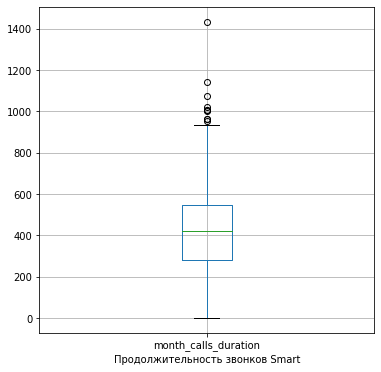

In [64]:
smart_df.boxplot('month_calls_duration', figsize=(6,6))
plt.xlabel('Продолжительность звонков Smart');

In [65]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

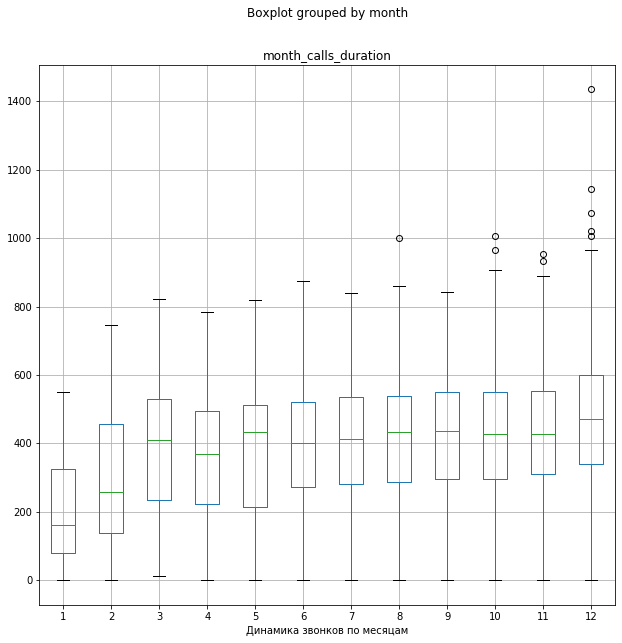

In [66]:
smart_df.boxplot('month_calls_duration', by='month', figsize=(10,10))
plt.xlabel('Динамика звонков по месяцам');

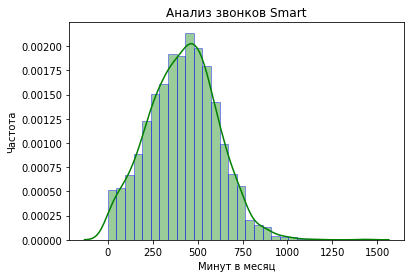

In [67]:
sns.distplot(smart_df['month_calls_duration'], hist=True, 
             bins=30, color = 'g',
             hist_kws={'edgecolor':'b'}).set_title('Анализ звонков Smart')

plt.xlabel("Минут в месяц") 
plt.ylabel("Частота");

Распределение нормальное.  
Среднее значение и медиана лежат близко друг к другу.
Среднее количество минут приближается к тарифному лимиту и при этом среднее отклонение (190мин) составляет 38% от лимита (500мин)- Абоненты не укладываются в лимит и приобретают дополнительные минуты.   

Вычислим % отношение выручки от минут сверх тарифного плана к общей выручке        

In [68]:
(smart_df.query('minutes_overrun > 0')['minutes_overrun'].sum() * 3) / smart_df['income'].sum()

0.09675931738420805

Выручка от минут сверх тарифного плана составляет почти 10% ко всей выручке по тарифу   

Посчитаем % отношение выручки от минут сверх тарифного плана к выручке по абон.плате (2229 абонетов по 550 руб.)        


In [69]:
(smart_df.query('minutes_overrun > 0')['minutes_overrun'].sum() * 3) / (2229 * 550)

0.2269399241404625

Выручка от доп.минут составляет 23% к абоненской плате  

In [70]:
smart_df.query('minutes_overrun > 0')['minutes_overrun'].count()

754

754 наблюдения с превышением количества пакетных минут по тарифу Smart.  

Посмотрим, есть ли абоненты на Smart, которые использовали бы все 3000 минут на тарифе Ultra

In [71]:
smart_df.query('month_calls_duration > 3000')['month_calls_duration'].count()

0

Таких данных не обнаружено

#### Анализ интернет-трафика

In [72]:
smart_df['gb_total_in_month'].describe().round()

count    2229.0
mean       16.0
std         6.0
min         0.0
25%        13.0
50%        17.0
75%        20.0
max        38.0
Name: gb_total_in_month, dtype: float64

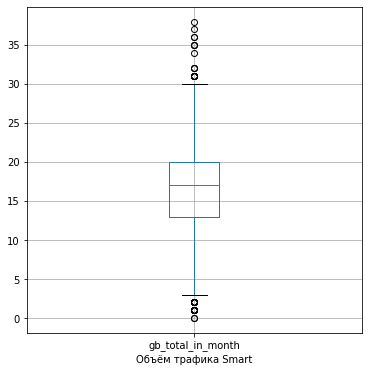

In [73]:
smart_df.boxplot('gb_total_in_month', figsize=(6,6))
plt.xlabel('Объём трафика Smart');

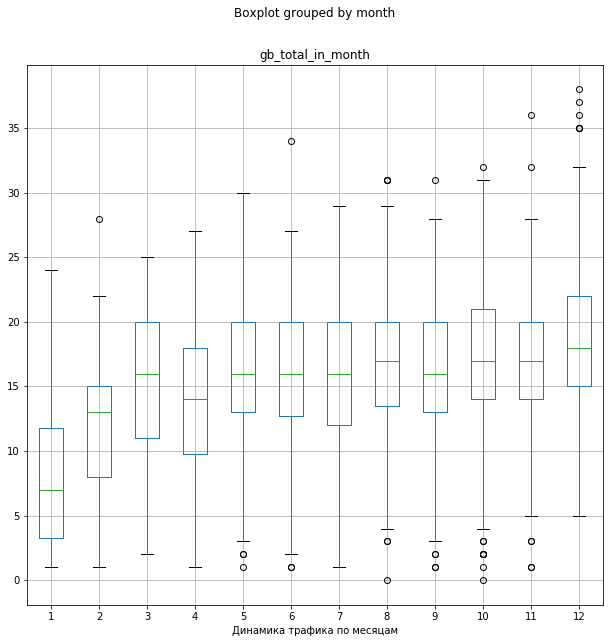

In [74]:
smart_df.boxplot('gb_total_in_month', by='month', figsize=(10,10))
plt.xlabel('Динамика трафика по месяцам');

In [75]:
variance = np.var(smart_df['gb_total_in_month'], ddof=1)
print('Дисперсия: ', variance.round(2))
print('Стандартное отклонение: ', np.sqrt(variance).round(2))
print('Среднее количество: ', smart_df['gb_total_in_month'].mean().round(2))

Дисперсия:  33.03
Стандартное отклонение:  5.75
Среднее количество:  16.33


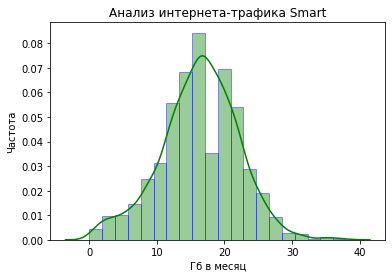

In [76]:
sns.distplot(smart_df['gb_total_in_month'], hist=True, 
             bins=20, color = 'g',
             hist_kws={'edgecolor':'b'}).set_title('Анализ интернета-трафика Smart')
plt.xlabel("Гб в месяц")
plt.ylabel("Частота");

Распределение нормальное - 15Гб входящих в пакетное предложение ниже среднего (16.37Гб). Большая часть абонентов платит за доплнительные Гб. Чем ниже среднего лимит, тем больше прибыли получает оператор сотовой связи «Мегалайн».

In [77]:
smart_df.query('gb_overrun > 0')['gb_overrun'].sum() #кол-во дополнительных gb

6662

In [78]:
smart_df.query('gb_overrun < 0')['gb_overrun'].sum() #кол-во тарифных gb 

0

In [79]:
(((smart_df.query('gb_overrun > 0')['gb_overrun'].sum() * 200) / smart_df['income'].sum()) * 100).round(2)

46.34

Выручка от дополнительно купленных Гб интернета составляет 46% от общей выручки по тарифу.  
Интересный результат.

In [80]:
((smart_df.query('gb_overrun > 0')['gb_overrun'].sum() * 200) / ((2229 * 550) -1)* 100).round(2)

108.68

Выручка от дополнительно купленных Гб интернета больше выручки от тарифа по лимиту (2229 наблюдений * 550 руб/мес) почти на 110%


In [81]:
smart_15 = smart_df.query('gb_overrun > 0')['gb_overrun'].count()
smart_15

1304

1310 раз был превышен лимит 15Гб

In [82]:
smart_15/ 2229

0.5850157021085689

Почти в 59% наблюдений был превышен пакетный лимит 15Гб     

In [83]:
smart_30 = smart_df.query('gb_total_in_month > 30')['gb_total_in_month'].count()
smart_30

18

Порог тарифа Ultra 30 Гб был превышен абонентами тарифа Smart 18 раз.     

#### Анализ сообщений

In [84]:
smart_df['sms_total_in_month'].describe().round()

count    2229.0
mean       33.0
std        28.0
min         0.0
25%        10.0
50%        28.0
75%        51.0
max       143.0
Name: sms_total_in_month, dtype: float64

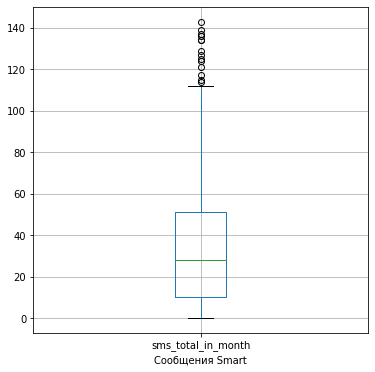

In [85]:
smart_df.boxplot('sms_total_in_month', figsize=(6,6))
plt.xlabel('Сообщения Smart');

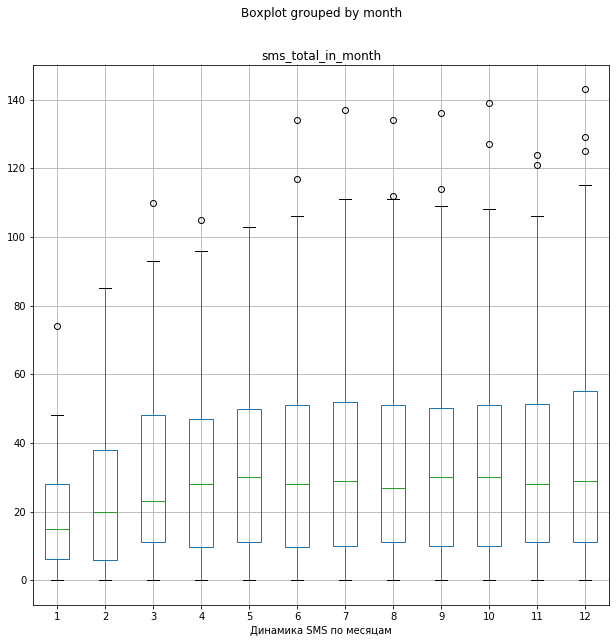

In [86]:
smart_df.boxplot('sms_total_in_month', by='month', figsize=(10,10))
plt.xlabel('Динамика SMS по месяцам');

In [87]:
variance = np.var(smart_df['sms_total_in_month'], ddof=1)
print('Дисперсия: ', variance.round(2))
print('Стандартное отклонение: ', np.sqrt(variance).round(2))
print('Среднее количество: ', smart_df['sms_total_in_month'].mean().round(2))

Дисперсия:  796.81
Стандартное отклонение:  28.23
Среднее количество:  33.38


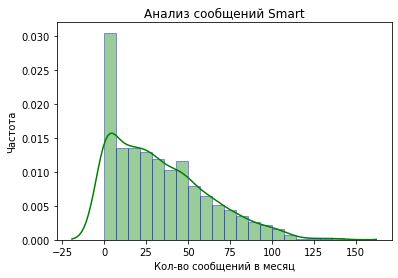

In [88]:
sns.distplot(smart_df['sms_total_in_month'], hist=True, 
             bins=20, color = 'g',
             hist_kws={'edgecolor':'b'}).set_title('Анализ сообщений Smart')

plt.xlabel("Кол-во сообщений в месяц") # подпись к оси X
plt.ylabel("Частота"); # подпись к оси Y

Распределение скошено вправо - 25% от всех месяцев использовали менее 10 сообщений.  
А 75% абонентов - укладывались в пакетные 50 сообщений.  
Только 25% отправляли дополнительные сообщения.  
Среднее количество отправляемых сообшений 33 немного больше среднего по лимиту тарифа (т.е. 25 сообщений из 50)

In [89]:
(smart_df.query('messages_overrun > 0')['messages_overrun'].sum() * 3) / (2229 * 550)

0.03163587421999266

Выручка от дополнительных сообщений составляет 3% к абонентской плате        

In [90]:
print('Кол-во дополнительных сообщений:', smart_df.query('messages_overrun > 0')['messages_overrun'].sum())
((smart_df.query('messages_overrun > 0')['messages_overrun'].sum() * 3) / smart_df['income'].sum()) * 100

Кол-во дополнительных сообщений: 12928.0


1.348844019391024

Выручка от дополнительных сообщений составляет всего 0,3% ко всей выручке по тарифу.  
Это вполне объяснимо, так как при использовании интернета потребность в SMS практически отпала.      

**Выводы:**  

В тариф Smart включено 50 сообщений, 15 ГБ, 500 минут, абонент плата - 550 руб.      
- 25% абонентов используют дополнительные сообщения.
- Больше 75% абонентов используют дополнительный объём интернет-трафика.
- Более 25% абонентов используют дополнительные минуты. 
- Средний ежемесячный платёж в 2 раза превышает абонентскую плату, преимущественно из-за дополнителных Гб. 

### Анализ тарифа 'Ultra'


In [91]:
ultra_df=df.query('tariff == "ultra"')
ultra_df.describe().round()

,user_id,month,month_calls_duration,calls_total_in_month,sms_total_in_month,gb_total_in_month,age,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,minutes_overrun,messages_overrun,gb_overrun,revenue,income
count,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0
mean,1263.0,8.0,527.0,73.0,49.0,19.0,47.0,1000.0,30.0,3000.0,1950.0,150.0,1.0,1.0,0.0,0.0,1.0,120.0,2070.0
std,141.0,3.0,318.0,44.0,48.0,10.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,376.0,376.0
min,1000.0,1.0,0.0,0.0,0.0,0.0,18.0,1000.0,30.0,3000.0,1950.0,150.0,1.0,1.0,0.0,0.0,0.0,0.0,1950.0
25%,1143.0,6.0,284.0,41.0,6.0,12.0,30.0,1000.0,30.0,3000.0,1950.0,150.0,1.0,1.0,0.0,0.0,0.0,0.0,1950.0
50%,1277.0,9.0,518.0,74.0,38.0,19.0,45.0,1000.0,30.0,3000.0,1950.0,150.0,1.0,1.0,0.0,0.0,0.0,0.0,1950.0
75%,1381.0,11.0,752.0,104.0,79.0,27.0,63.0,1000.0,30.0,3000.0,1950.0,150.0,1.0,1.0,0.0,0.0,0.0,0.0,1950.0
max,1495.0,12.0,1673.0,244.0,224.0,49.0,75.0,1000.0,30.0,3000.0,1950.0,150.0,1.0,1.0,0.0,0.0,19.0,2850.0,4800.0


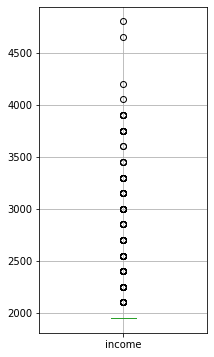

In [92]:
ultra_df.boxplot('income', figsize=(3,6))

In [93]:
#Сколько наблюдений превышают плату за тариф
ultra_df.query('income > 1950')['income'].count()

134

In [94]:
#Сколько % наблюдений превышают плату за тариф
ultra_df.query('income > 1950')['income'].count() / 985 * 100

13.604060913705585

In [95]:
#Какие суммы платят те, кто выходят за рамки тарифа
ultra_df['income'].value_counts()

1950.0    851
2250.0     21
2400.0     18
2550.0     13
2100.0     12
2700.0     10
3000.0     10
3300.0      9
3150.0      9
3750.0      9
2850.0      7
3900.0      6
3450.0      4
3600.0      2
4200.0      1
4650.0      1
4050.0      1
4800.0      1
Name: income, dtype: int64

#### Анализ звонков

In [96]:
ultra_df['month_calls_duration'].describe().round()

count     985.0
mean      527.0
std       318.0
min         0.0
25%       284.0
50%       518.0
75%       752.0
max      1673.0
Name: month_calls_duration, dtype: float64

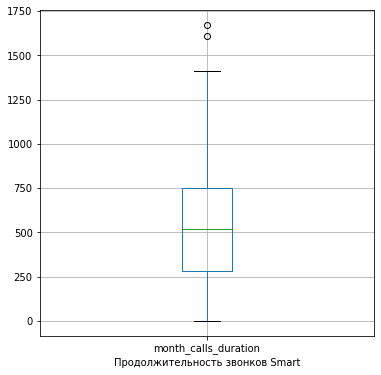

In [97]:
ultra_df.boxplot('month_calls_duration', figsize=(6,6))
plt.xlabel('Продолжительность звонков Smart');

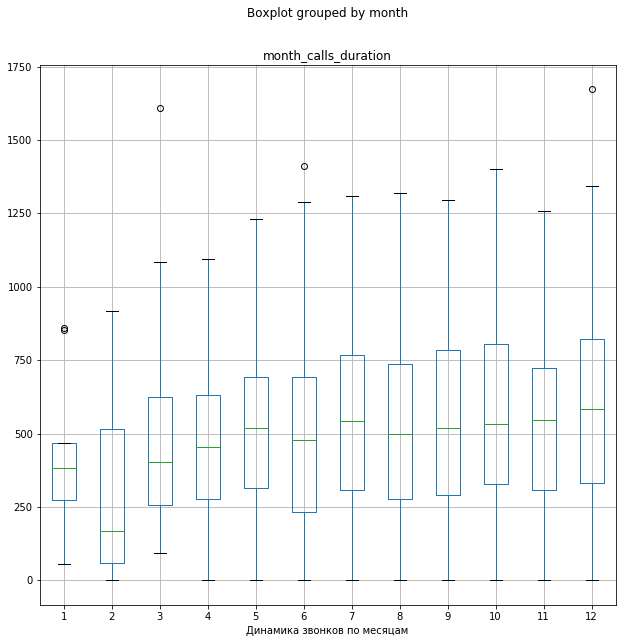

In [98]:
ultra_df.boxplot('month_calls_duration', by='month', figsize=(10,10))
plt.xlabel('Динамика звонков по месяцам');

In [99]:
variance = np.var(ultra_df['month_calls_duration'], ddof=1)
print('Дисперсия: ', variance.round(2))
print('Стандартное отклонение: ', np.sqrt(variance).round(2))
print('Среднее количество: ', ultra_df['month_calls_duration'].mean().round(2))

Дисперсия:  100873.63
Стандартное отклонение:  317.61
Среднее количество:  526.62


In [100]:
df.pivot_table(index='tariff',  
                 values=['month_calls_duration', 'gb_total_in_month', 'sms_total_in_month'], 
                 aggfunc=['mean', 'std', 'var']).T.style.format('{:.2f}')

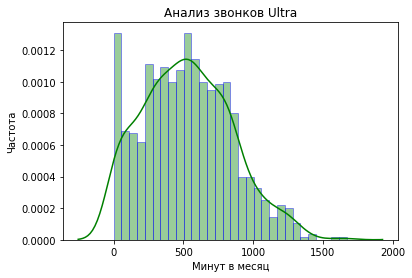

In [101]:
sns.distplot(ultra_df['month_calls_duration'], hist=True, 
             bins=30, color = 'g',
             hist_kws={'edgecolor':'b'}).set_title('Анализ звонков Ultra')

plt.xlabel("Минут в месяц") 
plt.ylabel("Частота");

Распределение чуть скошено влево, распределение умеренно ассиметричное.  
Среднее значение и медиана лежат близко друг к другу. 
Почти половина абонентов используют до 500 минут в месяц из возможных 3000 минут.
Высока частота пользователей, которые минимально пользуются минутами.
Абонентов превышающих тарифный лимит по минутам не обнаружено, значит нет и дополнительной выручки.

#### Анализ интернет-трафика

In [102]:
ultra_df['gb_total_in_month'].describe().round()

count    985.0
mean      19.0
std       10.0
min        0.0
25%       12.0
50%       19.0
75%       27.0
max       49.0
Name: gb_total_in_month, dtype: float64

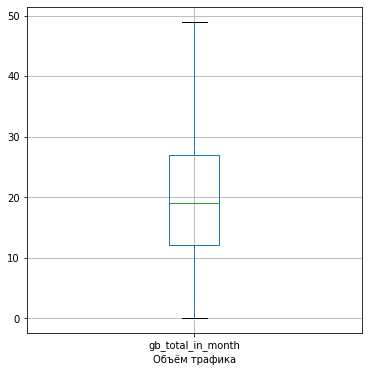

In [103]:
ultra_df.boxplot('gb_total_in_month', figsize=(6,6))
plt.xlabel('Объём трафика');

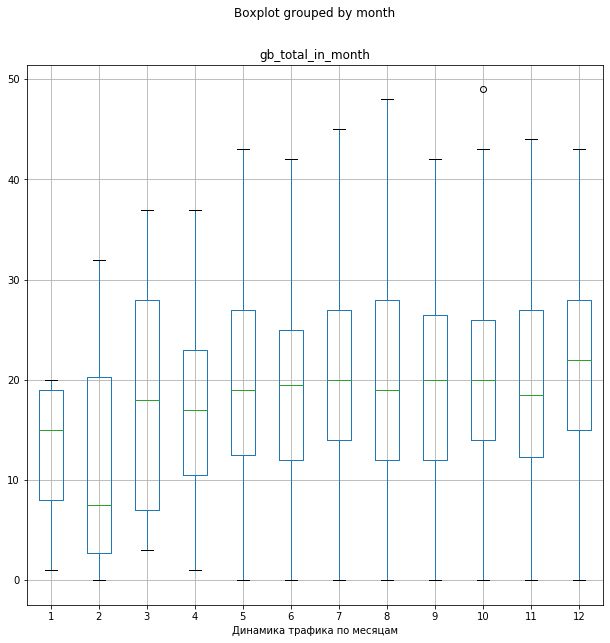

In [104]:
ultra_df.boxplot('gb_total_in_month', by='month', figsize=(10,10))
plt.xlabel('Динамика трафика по месяцам');

In [105]:
variance = np.var(ultra_df['gb_total_in_month'], ddof=1)
print('Дисперсия: ', variance.round(2))
print('Стандартное отклонение: ', np.sqrt(variance).round(2))
print('Среднее количество: ', ultra_df['gb_total_in_month'].mean().round(2))

Дисперсия:  97.09
Стандартное отклонение:  9.85
Среднее количество:  19.49


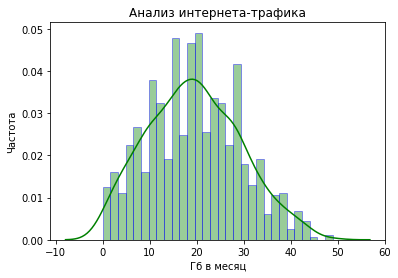

In [106]:
sns.distplot(ultra_df['gb_total_in_month'], hist=True, 
             bins=30, color = 'g',
             hist_kws={'edgecolor':'b'}).set_title('Анализ интернета-трафика')
plt.xlabel("Гб в месяц")
plt.ylabel("Частота");

По тарифу Ultra лимит интернета 30Гб.  
- Распределение нормальное, т.к. интернетом пользуются полноценно, звонки и сообщения часто через приложения и соответственно при помощи интернета. 
- Среднее и медиана 19-20 Гб, что очень схоже.
- 75% абонентов укладываются в лимит.    

In [107]:
ultra_df.query('gb_overrun > 0')['gb_overrun'].sum() #кол-во дополнительных gb

789

In [108]:
(((ultra_df.query('gb_overrun > 0')['gb_overrun'].sum() * 150) / smart_df['income'].sum()) * 100).round(2)

4.12

In [109]:
((ultra_df.query('gb_overrun > 0')['gb_overrun'].sum() * 150) / ((985 * 1950) -1)* 100).round(2)

6.16

Количество дополнительных Гб 795, что составляет 4.13% от общей выручки по тарифу. Выручка за дополнительные Гб на 6.21% больше выручки по тарифу (985 наблюдений * 1950 руб/мес) .

#### Анализ сообщений

In [110]:
ultra_df['sms_total_in_month'].describe().round()

count    985.0
mean      49.0
std       48.0
min        0.0
25%        6.0
50%       38.0
75%       79.0
max      224.0
Name: sms_total_in_month, dtype: float64

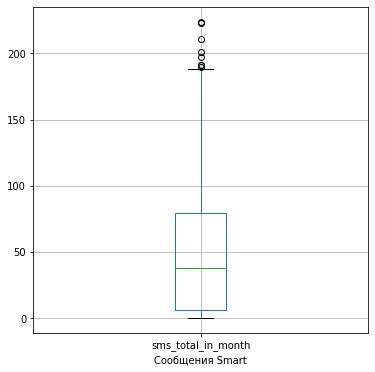

In [111]:
ultra_df.boxplot('sms_total_in_month', figsize=(6,6))
plt.xlabel('Сообщения Smart');

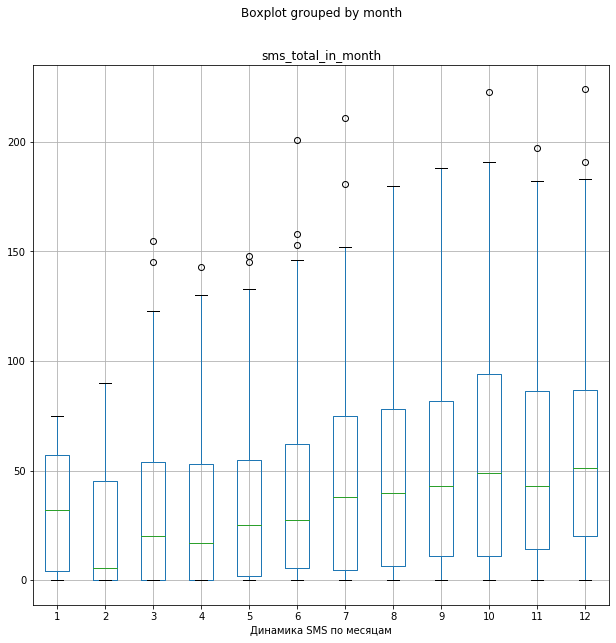

In [112]:
ultra_df.boxplot('sms_total_in_month', by='month', figsize=(10,10))
plt.xlabel('Динамика SMS по месяцам');

In [113]:
variance = np.var(ultra_df['sms_total_in_month'], ddof=1)
print('Дисперсия: ', variance.round(2))
print('Стандартное отклонение: ', np.sqrt(variance).round(2))
print('Среднее количество: ', ultra_df['sms_total_in_month'].mean().round(2))

Дисперсия:  2285.27
Стандартное отклонение:  47.8
Среднее количество:  49.36


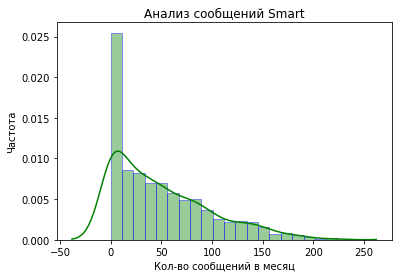

In [114]:
sns.distplot(ultra_df['sms_total_in_month'], hist=True, 
             bins=20, color = 'g',
             hist_kws={'edgecolor':'b'}).set_title('Анализ сообщений Smart')

plt.xlabel("Кол-во сообщений в месяц") # подпись к оси X
plt.ylabel("Частота"); # подпись к оси Y

В этом тарифе тоже наблюдается правосторонняя асимметрия в распределении по использованию сообщений.  
SMS практически изжили себя, и включать в пакет тарифа 1000 SMS довольно выгодно со стороны оператора.

In [115]:
print('Уложились бы в лимит 50 SMS:', ultra_df.query('sms_total_in_month <= 50')['sms_total_in_month'].count())
ultra_df.query('sms_total_in_month <= 50')['sms_total_in_month'].count()/ 985 * 100

Уложились бы в лимит 50 SMS: 586


59.492385786802025

Почти 60% абонентов тарифа Ultra уложились бы в лимит Smart (50 сообщений).

**Выводы:**  

В тариф Ultra входит 1000 сообщений, 30 гб, 3000 минут, абонет.плата - 1950р. 
- Максимальное кол-во в месяц сообщений было 224, минут 1673, что не превышает лимит. 
- А максимальное кол-во Гб в месяц было 49, причем в более чем 75% наблюдений лимит не превышался. 
- Только 13% наблюдений превышают абонентскую плату за тариф

## Проверка гипотез

### Проверка гипотезы: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Перед проверкой гипотез нужно избавиться от выбросов. Например, методом 3х сигм. Выбросы влияют на распределение t-критерия.

In [116]:
# Напишем функцию для удаления выбросов

def del_outliers(df, column, graphic=0, x = 10, y = 10):
    q1 = df[column].quantile(0.25)                 
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    iqr_test = (df[column] >= (q1 - 1.5 * iqr)) & (df[column] <= (q3 + 1.5 * iqr))
    if graphic == 1:
        return df.loc[iqr_test].boxplot([column], figsize=(x,y))
    else:
        return df.loc[iqr_test]

In [117]:
moscow = del_outliers(df.query('city == "Москва"'), 'income', 0)
moscow = moscow['income']

other = del_outliers(df.query('city != "Москва"'), 'income', 0)
other = other['income']

In [119]:
smart = del_outliers(df.query('tariff == "smart"'), 'income', 0)
smart = smart['income']

ultra = del_outliers(df.query('tariff == "ultra"'), 'income', 0)
ultra = ultra['income']

In [120]:
#Посмотрим выручку по тарифу smart до удаления выбросов
df.query('tariff == "smart"')['income'].describe().round()

count    2229.0
mean     1290.0
std       818.0
min       550.0
25%       550.0
50%      1023.0
75%      1750.0
max      6770.0
Name: income, dtype: float64

In [121]:
#Посмотрим выручку по тарифу smart после удаления выбросов
smart.describe().round()

count    2198.0
mean     1246.0
std       730.0
min       550.0
25%       550.0
50%      1006.0
75%      1750.0
max      3550.0
Name: income, dtype: float64

In [122]:
#Посмотрим выручку по тарифу ultra до удаления выбросов
df.query('tariff == "ultra"')['income'].describe().round()

count     985.0
mean     2070.0
std       376.0
min      1950.0
25%      1950.0
50%      1950.0
75%      1950.0
max      4800.0
Name: income, dtype: float64

In [123]:
#Посмотрим выручку по тарифу ultra после удаления выбросов
ultra.describe().round()

count     851.0
mean     1950.0
std         0.0
min      1950.0
25%      1950.0
50%      1950.0
75%      1950.0
max      1950.0
Name: income, dtype: float64

Средняя выручка по тарифам Смарт и Ультра до удаления выбросов равны 1290 руб. и 2070 руб соответственно.  
Средняя выручка по тарифам Смарт и Ультра после удаления выбросов равны 1246 руб. и 1950 руб соответственно.  


**Сформулируем гипотезы:**

H0: выручка пользователей тарифов «Ультра» и «Смарт» не различается  
H1: выручка пользователей тарифов «Ультра» и «Смарт» различается  


Используем метод scipy.stats.ttest_ind (array1, array2, equal_var = False). False, потому что дисперсии наших выборок отличаются.
Критический уровень значимости 0.01. Пусть вероятность правильности вывода будет 99% и больше

In [124]:
#до удаления выбросов
alpha = 0.01

results = st.ttest_ind(df.query('tariff == "ultra"')['income'], df.query('tariff == "smart"')['income'], equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 4.2606313931076085e-250
Отвергаем нулевую гипотезу


Нулевой гипотезой была гипотеза о неравенстве средних наших выборок и очень маленькое p-value говорит нам о том, вероятность случайного совпадения средних наших выборок ничтожно мало.  
Нулевая гипотеза отвергается.

In [125]:
#после удаления выбросов
alpha = 0.01

results = st.ttest_ind(ultra, smart, equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 4.665521e-316
Отвергаем нулевую гипотезу


**Вывод по гипотезе 1:**

Нулевой гипотезой была гипотеза о равенстве средних наших выборок и очень маленькое p-value означает, что вероятность случайного совпадения средних наших выборок ничтожно мало. Нулевая гипотеза отвергается.

А значит альтернативная гипотеза о том, что средние наших выборок отличаются, не отвергается!  
Выручка между двумя тарифами отличается, но так как гипотеза двухсторонняя, то сама проверка не даёт нам понять в какую именно сторону оно отличается, и что приносит больше выручки.  
Но как мы уже выяснили ранее: средняя выручка по тарифам Ультра и Смарт равны 1290 руб. и 2070 руб соответственно. 

### Проверка гипотезы: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [126]:
print('Уникальные значения название города')
print(df['city'].value_counts())

Уникальные значения название города
Москва             611
Санкт-Петербург    270
Новосибирск         98
Уфа                 95
Краснодар           86
                  ... 
Нижневартовск        6
Сургут               6
Кемерово             5
Химки                5
Иваново              2
Name: city, Length: 76, dtype: int64


In [127]:
#Посмотрим выручку по Москве до удаления выбросов
df.query('city == "Москва"')['income'].describe().round()

count     611.0
mean     1547.0
std       752.0
min       550.0
25%       780.0
50%      1750.0
75%      1950.0
max      5321.0
Name: income, dtype: float64

In [128]:
#Посмотрим выручку по Москве после удаления выбросов
moscow.describe().round()

count     606.0
mean     1525.0
std       713.0
min       550.0
25%       758.0
50%      1750.0
75%      1950.0
max      3450.0
Name: income, dtype: float64

In [129]:
#Посмотрим выручку по другим регионам до удаления выбросов
df.query('city != "Москва"')['income'].describe().round()

count    2603.0
mean     1525.0
std       809.0
min       550.0
25%       750.0
50%      1583.0
75%      1950.0
max      6770.0
Name: income, dtype: float64

In [130]:
#Посмотрим выручку по другим регионам до удаления выбросов
other.describe().round()

count    2572.0
mean     1490.0
std       743.0
min       550.0
25%       750.0
50%      1552.0
75%      1950.0
max      3750.0
Name: income, dtype: float64

Средняя выручка до удаления выбросов пользователей из Москвы и других городов равны 1551 руб. и 1529 руб соответственно. 
Средняя выручка после удаления выбросов пользователей из Москвы и других городов равны 1529 руб. и 1493 руб соответственно.  
Средние выручки практически действительно равны, есть лишь небольшое различие 

**Сформулируем гипотезы:**

H0: средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов  
H1: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [131]:
#до удаления выбросов
alpha = 0.01

results = st.ttest_ind(df.query('city == "Москва"')['income'], df.query('city != "Москва"')['income'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.5440152911670224
Не получилось отвергнуть нулевую гипотезу


In [132]:
#после удаления выбросов
alpha = 0.01

results = st.ttest_ind(moscow, other)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.29404256281786195
Не получилось отвергнуть нулевую гипотезу


Полученное нами p-value достаточно велик, а значит есть большая вероятность того, что отличие средних значений наших выборок случайно и мы не можем отвергнуть нулевую гипотезу, которая говорит нам о равенстве средних значений.

Значит, нашу альтернативную гипотезу о различии средних мы отвергаем!

## Результаты исследования

### Выводы

В ходе исследования тарифов «Смарт» и «Ультра» на небольшой выборке клиентов мы обработали несколько массивов данных.  
Мы вывели из предоставленных нам таблиц все необходимые средние значения израсходованных минут, мегабайтов интернет-трафика и сообщений, а также вычислили прибыль по ним по каждому месяцу и посчитали по каждому из клиентов среднюю прибыль для компании. Далее мы разделили всех клиентов по тарифным группам и проверили правильность нашеих гипотез.

Самый популярным тарифом оказался Смарт.

Оказалось, что средняя выручка по тарифам Смарт и Ультра равны 1290 руб. и 2070 руб соответственно.

Мы выяснили, что средние израсходованные количества звонков, сообщений и мегабайт интернет трафика не так сильно отличаются между тарифами, тогда как базовая стоимость тарифов отличается почти в 4 раза.

75% абонентов «Смарт» не укладываются в лимит и платит за добольнительный трафик, чем приносит оператору порядка 46% выручки от тарифа. Средний ежемесячный платёж в 2 раза превышает абонентскую плату.

Более 25% абонентов «Смарт» используют дополнительные минуты и сообщения. 

Максимальное кол-во в месяц сообщений минут на тарифе «Ультра» не превышает лимит и не приносит дополнительной выручки. У более чем 75% наблюдений лимит по интернет трафику также не превышался. Только 13% наблюдений превышают абонентскую плату за тариф

Средние выручки Москвы и остальных регионов практически равны, есть лишь небольшое различие.

### Рекомендации

Можно рекомендовать оператору скорректировать рекламный бюджет в пользу тарифа Смарт.  
Он приносит больше выручки, за счёт того, что его абоненты переплачивают сверх лимита, в отличие от абонентов Ультры, которые крайне редко выбирают свой лимит.  

Также по абонентской плате он более привлекателен для абонентов, значит может быть более популярным и будет приносить суммарно бОльшую выручку.  
Для привлечения клиентов можно дополнительно уменьшить абонентскую плату на первые месяцы или добавить в этот тариф минуты и сообщения.

Но если учитывать, что тариф Ультра приносит выручку на 38% больше, чем Смарт, то стоит оценить стоимость привлечения одного абонента по каждому тарифу. И исходя из сравнения стоимости привлечения делать более точные оценки. 